# Analysis for calculating score for Alerts


## Getting and Preparing Data

This section loads sample data for 2015-05-21 records of activities, rules and actors.

In [101]:
%matplotlib inline

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import math
import time
from pandas.tools.plotting import scatter_matrix
from datetime import datetime
from time import gmtime, strftime

### Activities

In [70]:
activities_cols_names = ["id","body", "country", "country_code", "place_type",
                       "sub_region", "actor_id", "source", "share_count",
                       "in_reply_to_native_id", "created_at", "updated_at",
                       "klout", "native_id", "verb", "latitude", "longitude",
                       "sharing_activity_native_id", "region", "favorites_count",
                       "replies_count", "in_reply_to_screen_name", "link"]

In [71]:
activities_relevant_cols = ["actor_id", "source", "share_count",
                           "in_reply_to_native_id", "created_at", "klout", 
                           "verb", "favorites_count", "replies_count"]

In [72]:
activities = pd.read_csv('../../s3/2015-05-21-01-00-00-activities.csv', 
                         header=None, parse_dates=True,
                         names=activities_cols_names, index_col="id")

In [73]:
activities = activities[activities_relevant_cols] 

In [88]:
activities['created_at'] = pd.to_datetime(activities['created_at'], format="%Y-%m-%d %H:%M:%S.%f")

In [89]:
activities.head()

,actor_id,source,share_count,in_reply_to_native_id,created_at,klout,verb,favorites_count,replies_count
id,,,,,,,,,
443640355408254904,2419819735,twitter,0,NaN,2015-05-21 01:00:00,48,post,0,0
443640355408254905,2405587887,twitter,0,NaN,2015-05-21 01:00:00,54,post,0,0
443640355408254907,2425857238,twitter,0,NaN,2015-05-21 01:00:00,31,post,0,0
443640355408254908,2422152815,twitter,9,NaN,2015-05-21 01:00:00,19,share,14,0
443640355408254909,2406991214,twitter,0,NaN,2015-05-21 01:00:00,35,post,0,0


In [11]:
activities.describe()

,share_count,klout,favorites_count
count,1.280768e+06,1.255925e+06,1280865.000000
mean,1.878510e+12,4.836412e+13,3338.222079
std,1.062963e+15,5.392960e+15,13146.340361
min,0.000000e+00,1.000000e+01,0.000000
25%,1.000000e+00,2.900000e+01,0.000000
50%,6.000000e+01,4.000000e+01,54.000000
75%,7.090000e+02,4.500000e+01,782.000000
max,6.015506e+17,6.015513e+17,462900.000000


### Association Activities-Rules

In [12]:
activities_rules_cols_names = ["id", "rule_id", "activity_id", "created_at", "updated_at", "ignored"]

In [13]:
activities_rules = pd.read_csv('../../s3/2015-05-21-01-00-00-activities-rules.csv', 
                               parse_dates=True, names=activities_rules_cols_names, index_col="id")

In [14]:
activities_rules_relevant_cols = ["rule_id", "activity_id", "ignored"]

In [15]:
activities_rules = activities_rules[activities_rules_relevant_cols]

In [16]:
activities_rules.head()

,rule_id,activity_id,ignored
id,,,
108642970,5772,4.436404e+17,0
108642971,5052,4.436404e+17,0
108642972,5428,4.436404e+17,0
108642973,1506,4.436404e+17,0
108642974,5077,4.436404e+17,0


### Rules

In [17]:
rules = pd.read_csv('../../s3/rule.csv', index_col="id")

In [18]:
rules_relevant_cols = ["business_id","segment","volume", "category", "source", "type", "direct"]

In [19]:
rules = rules[rules_relevant_cols]

In [20]:
rules.head()

,business_id,segment,volume,category,source,type,direct
id,,,,,,,
1,144,1,0,2,twitter,TwitterRule,False
2,144,1,0,2,twitter,TwitterRule,False
3,144,1,0,2,twitter,TwitterRule,False
4,144,1,0,2,twitter,TwitterRule,False
5,144,1,0,2,twitter,TwitterRule,False


In [21]:
rules.describe()

,business_id,segment,volume,category,direct
count,4786.000000,4786.000000,4.464000e+03,4786.000000,4786
mean,314.314668,0.376097,2.326812e+05,3.243627,0.0215211
std,125.258811,0.484455,8.564815e+06,1.819087,0.1451287
min,1.000000,0.000000,0.000000e+00,0.000000,False
25%,262.000000,0.000000,1.600000e+01,2.000000,0
50%,354.000000,0.000000,2.970000e+02,3.000000,0
75%,412.000000,1.000000,3.140250e+03,5.000000,0
max,460.000000,1.000000,4.750714e+08,6.000000,True


### Actors

In [22]:
actors = pd.read_csv('../../s3/actors.csv', index_col="id")

In [23]:
actors.head()

,lang,favourites_count,statuses_count,friends_count,followers_count,listed_count
id,,,,,,
12,en,NaN,16636,1450,2984845,24425
767,en,24198,69163,2983,90600,4884
785,en,NaN,23948,846,14979,631
1952,en,94,41700,998,4043,226
2172,en,76,53560,2033,582423,12127


In [24]:
actors.describe()

,favourites_count,statuses_count,friends_count,followers_count,listed_count
count,72205.000000,734833.000000,734834.000000,734834.000000,734611.000000
mean,2063.706627,17198.639341,989.087618,3778.709121,32.093360
std,6821.231790,34693.571539,6001.745585,155812.787824,1135.065026
min,0.000000,0.000000,-438.000000,0.000000,0.000000
25%,36.000000,1385.000000,173.000000,133.000000,0.000000
50%,343.000000,5884.000000,358.000000,343.000000,2.000000
75%,1703.000000,18786.000000,779.000000,853.000000,7.000000
max,492244.000000,2051862.000000,1593446.000000,64199466.000000,821163.000000


### Alerts

In [25]:
alerts = pd.read_csv('../../s3/alerts.csv', index_col="id")

In [26]:
alerts.head()

,business_id,options,created_at,updated_at,alert_type_id,type,rule_id
id,,,,,,,
173559,397,"{""klout_topics""=>""Baseball, College Baseball, ...",2015-05-21 00:00:15 -0400,2015-05-21 00:00:15 -0400,129,NaN,3454
173560,435,"{""klout_topics""=>""Sacramento, Twitter, San Jos...",2015-05-21 00:04:30 -0400,2015-05-21 00:04:30 -0400,129,NaN,4561
173561,439,"{""klout_topics""=>""Architecture, Interior Desig...",2015-05-21 00:09:26 -0400,2015-05-21 00:09:26 -0400,129,NaN,5183
173562,421,"{""hashtags""=>[""usocwithbdpc""], ""topic""=>""\""son...",2015-05-21 00:12:43 -0400,2015-05-21 00:12:43 -0400,118,HashtagAlert,4268
173563,369,"{""mean""=>""28.6667"", ""topic""=>""@pgatour"", ""vali...",2015-05-21 00:12:44 -0400,2015-05-21 00:12:44 -0400,142,PopularTopicAlert,2872


In [27]:
alerts.describe()

,business_id,alert_type_id,rule_id
count,620.000000,620.000000,620.000000
mean,307.483871,133.143548,3257.156452
std,155.333530,6.910251,1998.946054
min,1.000000,113.000000,20.000000
25%,224.000000,129.000000,1450.750000
50%,369.000000,129.000000,3616.000000
75%,443.000000,141.000000,5269.000000
max,453.000000,146.000000,5897.000000


### Activities for URLs of Alerted Trends

In [28]:
activities_urls = pd.read_csv('../../s3/activities_urls_trends.csv', index_col="id")
activities_urls = activities_urls[activities_relevant_cols +["created_at","activities_count","expanded_url"]]
activities_urls = activities_urls.sort("activities_count", ascending=False)
activities_urls['created_at'] = pd.to_datetime(activities_urls['created_at'], format="%Y-%m-%d %H:%M:%S")

In [29]:
activities_urls.head()

,actor_id,source,share_count,in_reply_to_native_id,klout,verb,favorites_count,replies_count,created_at,activities_count,expanded_url
id,,,,,,,,,,,
443640355408832882,2424761055,twitter,671,NaN,17,share,468,0,2015-05-21 09:43:58,701,http://twitter.com/footy_jokes/status/60133160...
443640355408700115,2424174321,twitter,400,NaN,25,share,246,0,2015-05-21 07:02:32,701,http://twitter.com/footy_jokes/status/60133160...
443640355408701789,2424330443,twitter,407,NaN,31,share,251,0,2015-05-21 07:04:55,701,http://twitter.com/footy_jokes/status/60133160...
443640355408701608,2408455207,twitter,406,NaN,34,share,251,0,2015-05-21 07:04:38,701,http://twitter.com/footy_jokes/status/60133160...
443640355408701432,2426154688,twitter,405,NaN,29,share,249,0,2015-05-21 07:04:24,701,http://twitter.com/footy_jokes/status/60133160...


In [30]:
activities_urls.describe()

,actor_id,share_count,in_reply_to_native_id,klout,favorites_count,replies_count,activities_count
count,1.909000e+03,1909.000000,0,1893.000000,1909.000000,1909.000000,1909.000000
mean,2.178678e+09,259.558931,NaN,34.382990,189.161865,0.020430,432.473023
std,6.706268e+08,228.450609,NaN,11.030357,166.035460,0.523155,233.626166
min,1.819261e+06,0.000000,NaN,10.000000,0.000000,0.000000,12.000000
25%,2.407298e+09,79.000000,NaN,27.000000,35.000000,0.000000,194.000000
50%,2.415558e+09,191.000000,NaN,34.000000,159.000000,0.000000,446.000000
75%,2.423687e+09,390.000000,NaN,42.000000,311.000000,0.000000,701.000000
max,2.426304e+09,975.000000,NaN,90.000000,615.000000,21.000000,701.000000


In [31]:
activities_urls_full = pd.read_csv('../../s3/activities_urls.csv')
activities_urls_full['created_at'] = pd.to_datetime(activities_urls_full['created_at'], format="%Y-%m-%d %H:%M:%S")

## Data Analysis

This section performs some data analysis over activities data in order to statistically measure the significance of variables.

### Regression Models

In [90]:
# Merge Activities and Actors data to build a regression model over it
regdata = pd.merge(activities[["share_count","klout","actor_id", "created_at"]], 
                   actors[["followers_count", "listed_count"]], 
                   left_on="actor_id", right_index=True)

# Add column with a float representation of hour and minute of activity
regdata["numeric_time"] = map(lambda t: float(t.hour) + float(t.minute)/60, 
                              regdata["created_at"].tolist())

In [98]:
def fit_regression_model(formula, data):
    # Fit regression model
    results = smf.ols(formula, data=data).fit()

    # Inspect the results
    print results.params
    print results.bse
    print results.summary()
    
fit_regression_model('share_count ~ klout + followers_count + listed_count + numeric_time', regdata)

Intercept          2517.118821
klout               -10.173976
followers_count       0.000022
listed_count         -0.026333
numeric_time          7.929058
dtype: float64
Intercept          71.015778
klout               1.654657
followers_count     0.000080
listed_count        0.010350
numeric_time        2.304744
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            share_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     16.86
Date:                Wed, 03 Jun 2015   Prob (F-statistic):           7.87e-14
Time:                        21:31:43   Log-Likelihood:            -2.8042e+06
No. Observations:              263434   AIC:                         5.608e+06
Df Residuals:                  263429   BIC:                         5.608e+06
Df Model:                           4 

In [100]:
fit_regression_model('share_count ~ klout + numeric_time', regdata)

Intercept       2546.146685
klout            -11.027470
numeric_time       7.938299
dtype: float64
Intercept       70.331146
klout            1.629454
numeric_time     2.304781
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            share_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     28.18
Date:                Wed, 03 Jun 2015   Prob (F-statistic):           5.79e-13
Time:                        21:32:16   Log-Likelihood:            -2.8042e+06
No. Observations:              263434   AIC:                         5.608e+06
Df Residuals:                  263431   BIC:                         5.608e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  

### Scatter Matrix - correlation among variables

array([[<matplotlib.axes.AxesSubplot object at 0x119c4cfd0>,
        <matplotlib.axes.AxesSubplot object at 0x13033c690>]], dtype=object)

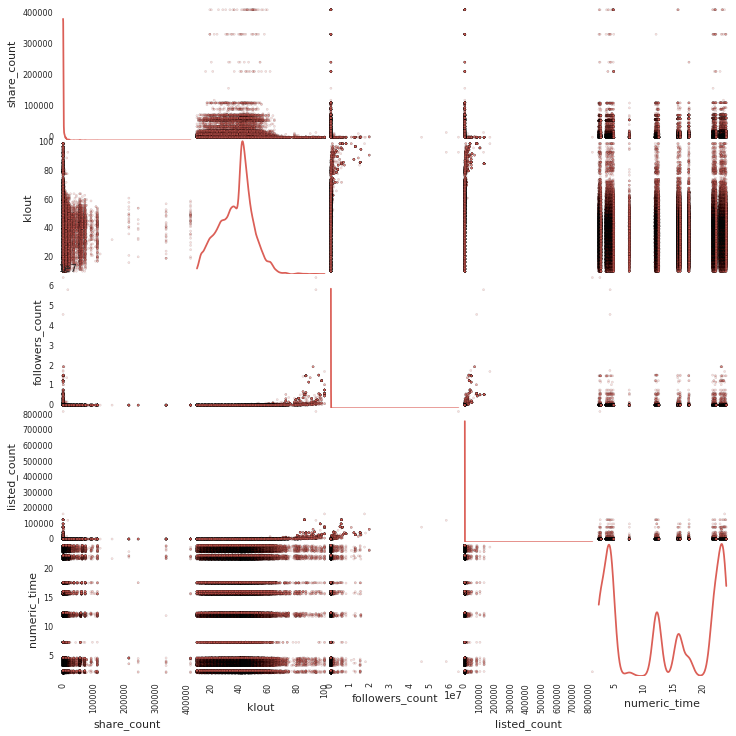

In [103]:
scatter_matrix(regdata, alpha=0.2, figsize=(12, 12), diagonal='kde')

## Computing Scores

This section implements the functions for computing and the scores and performs some tests for subsequent validation.

### Alert type - Influencer


- Legend:
    - k = klout
    - f = followers
    - l = listed count
    - v = verb
    - kw = klout weight
    - fw = followers count weight
    - lw = listed count weight

- Values:
    - kw = 30
    - fw = 40
    - lw = 30
    - v = (tweet=1, retweet=0.9)

**influencer_score** = (2-v) \* kw \* (k^2) / 10000 +
                        v \* fw \* log(f) / 20 +
                        v \* lw \* log(l) / 15


In [33]:
def generate_influencer_score(activity_id, k=None, f=None, l=None, verb="post"):
    # Weights for klout, followers and lists
    kw = 30.0
    fw = 40.0
    lw = 30.0
    
    # Default behavior when activity_id is provided
    if activity_id is not None:
        activity = activities.loc[str(activity_id)]
        actor = actors.loc[int(activity.actor_id)]
        if not activity.klout.is_integer():
            k = 0.0
    
        # Obtain values from activity unless parameterized
        if k is None: k = float(activity.klout)
        if f is None: f = float(actor.followers_count + 1.0)
        if l is None: l = float(actor.listed_count + 1.0)
    
    # Coefficient for tweet(verb=post) or retweet(verb=share)
    v = 1.0 if verb=="post" else 0.9
    
    # Score calculation and return
    return int((2-v)*kw * float(k ** 2) / 10000 + \
                v * fw * math.log(f) / 20 + \
                v * lw * math.log(l) / 15)

In [34]:
for index, row in activities.head(30).iterrows():
    print "Generated score for activity {0}: {1}".format(index,generate_influencer_score(index))

Generated score for activity 443640355408254904: 29
Generated score for activity 443640355408254905: 22
Generated score for activity 443640355408254907: 20
Generated score for activity 443640355408254908: 7
Generated score for activity 443640355408254909: 18
Generated score for activity 443640355408254910: 14
Generated score for activity 443640355408254912: 28
Generated score for activity 443640355408254913: 7
Generated score for activity 443640355408254914: 30
Generated score for activity 443640355408254916: 23
Generated score for activity 443640355408254917: 12
Generated score for activity 443640355408254920: 30
Generated score for activity 443640355408254922: 16
Generated score for activity 443640355408254923: 22
Generated score for activity 443640355408254926: 12
Generated score for activity 443640355408254927: 47
Generated score for activity 443640355408254928: 16
Generated score for activity 443640355408254934: 57
Generated score for activity 443640355408254915: 42
Generated scor

Now testing with predefined values for evaluating limits:

In [35]:
generate_influencer_score(activity_id=None, k=99, f=50000000, l=50000000, verb='post')

100

In [36]:
generate_influencer_score(activity_id=None, k=90, f=50000000, l=50000000, verb='post')

95

In [37]:
generate_influencer_score(activity_id=None, k=99, f=50000000, l=50000000, verb='share')

96

In [38]:
generate_influencer_score(activity_id=None, k=90, f=50000000, l=50000000, verb='share')

90

In [39]:
generate_influencer_score(activity_id=None, k=70, f=5000000, l=5000000, verb='post')

76

In [40]:
generate_influencer_score(activity_id=None, k=70, f=5000000, l=5000000, verb='share')

71

In [41]:
generate_influencer_score(activity_id=None, k=50, f=5000000, l=5000000, verb='post')

69

In [42]:
generate_influencer_score(activity_id=None, k=50, f=5000000, l=5000000, verb='share')

63

In [43]:
generate_influencer_score(activity_id=None, k=50, f=1000000, l=1000000, verb='post')

62

In [44]:
generate_influencer_score(activity_id=None, k=50, f=1000000, l=1000000, verb='share')

57

### Alert type - Trends
* Reach of tweets
* segment: marketing (categories: range from 1 to 10) vs business(15% more important than Marketing)

* Try to analyze: Potential, Virality

**trend_score** = reach + segment


In [45]:
activities_urls_full.tail()

,created_at,verb,expanded_url
812791,2015-05-21 15:37:33,share,http://twitter.com/RapUp/status/60141425162276...
812792,2015-05-21 15:37:33,share,http://twitter.com/TheLadBible/status/60139499...
812793,2015-05-21 15:37:33,post,http://migration.kentucky.gov/newsroom/governo...
812794,2015-05-21 15:37:33,post,http://www.humtvdramas.net
812795,2015-05-21 15:37:33,post,http://i.imgur.com/9rLQ3TP.jpg


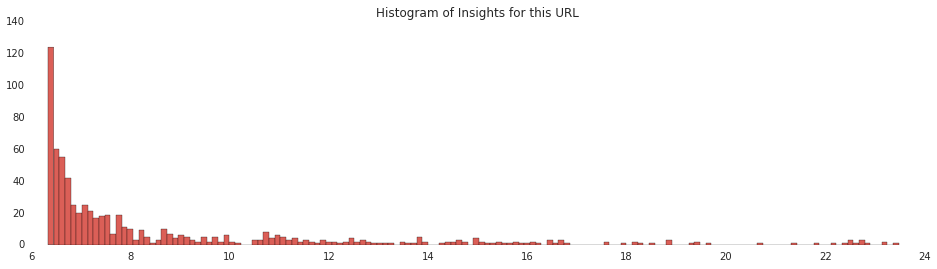

In [55]:
def plot_trend_histogram(url_param):
    insights_for_url = activities_urls[activities_urls["expanded_url"]==url_param]

    time_list = insights_for_url["created_at"].tolist()
    numeric_time_list = map(lambda t: float(t.hour) + float(t.minute)/60, time_list)

    sns.set_palette("hls")
    plt.hist(numeric_time_list, 150)
    mpl.rc("figure", figsize=(16, 4))
    plt.title("Histogram of Insights for this URL")
    plt.show()
    
#     mpl.rc("figure", figsize=(16, 4))
#     sns.distplot(numeric_time_list, 150);
    
plot_trend_histogram("http://twitter.com/footy_jokes/status/601331607371390976/photo/1")

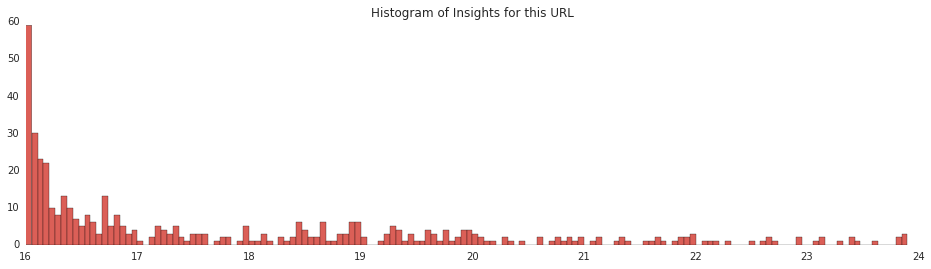

In [56]:
plot_trend_histogram("http://www.manutd.com/en/tour%202015/news%20and%20features/2015/may/manchester%20united%20to%20face%20san%20jose%20earthquakes%20at%20california%20memorial%20stadium.aspx")

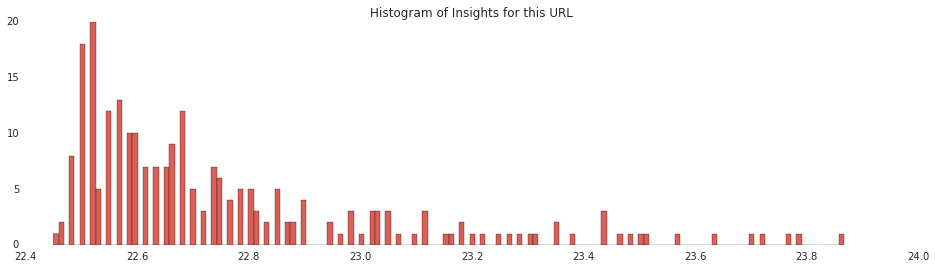

In [57]:
plot_trend_histogram("http://deadspin.com/lets-take-a-look-at-andrew-mccutchens-pay-stub-1706188663")

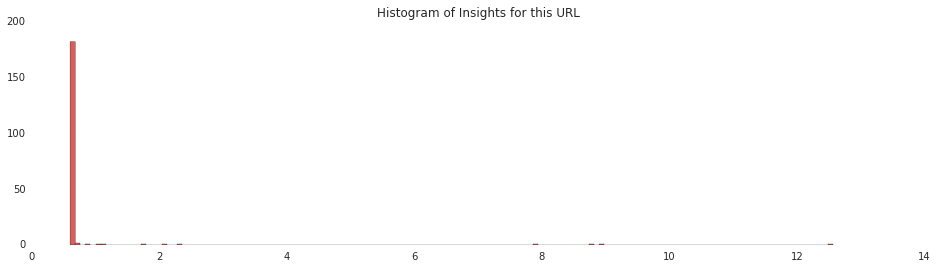

In [58]:
plot_trend_histogram("https://twitter.com/perla69biebs/status/601239506763649025/video/1")

### Alert type - Popular Tweet
* Engagement of tweet
* Potential of engagement

**popular_score** = engagement + potential


In [ ]:
# TODO